<a href="https://colab.research.google.com/github/maclandrol/cours-ia-med/blob/master/04_Classification_Texte_Medical_Francais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. Classification de Texte Médical Français

**Enseignant:** Emmanuel Noutahi, PhD

---

**Objectif:** Apprendre à classifier des textes médicaux en français en utilisant des approches de prompting et d'apprentissage automatique.

**Dataset:** FrenchMedMCQA - Questions à choix multiples de pharmacie

**Approches:**
- Prompting avec ChatGPT
- Classification automatique avec CamemBERT

## Installation et Configuration

In [ ]:
!pip install "datasets<4.0.0" transformers torch pandas scikit-learn matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositif: {device}")

Dispositif: cuda


## 1. Accès aux Données

In [ ]:
# Chargement du dataset FrenchMedMCQA
dataset = load_dataset("qanastek/frenchmedmcqa")
print(f"Dataset chargé: {len(dataset['train'])} exemples")

Dataset chargé: 2171 exemples


## 2. Transformation en DataFrame

In [ ]:
# Conversion en DataFrame
df = pd.DataFrame(dataset['train'])
print(f"DataFrame: {df.shape}")
print(f"Colonnes: {list(df.columns)}")

DataFrame: (2171, 9)
Colonnes: ['id', 'question', 'answer_a', 'answer_b', 'answer_c', 'answer_d', 'answer_e', 'correct_answers', 'number_correct_answers']


## 3. Analyse dataset


In [ ]:
# Statistiques de base
print(f"Nombre de questions: {len(df)}")
print(f"Longueur moyenne des questions: {df['question'].str.len().mean():.0f} caractères")

# Distribution des réponses correctes
answer_counts = df['correct_answers'].apply(len).value_counts().sort_index()
print("\nNombre de bonnes réponses par question:")
for nb, count in answer_counts.items():
    print(f"  {nb} réponse(s): {count} questions")

Nombre de questions: 2171
Longueur moyenne des questions: 100 caractères

Nombre de bonnes réponses par question:
  1 réponse(s): 595 questions
  2 réponse(s): 528 questions
  3 réponse(s): 718 questions
  4 réponse(s): 296 questions
  5 réponse(s): 34 questions


In [ ]:
# Exemple de question
exemple = df.iloc[0]
print("Exemple de question:")
print(f"Q: {exemple['question']}")

Exemple de question:
Q: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha


## 4. Prompting avec ChatGPT

### Le Rôle du Prompting

Le prompting consiste à formuler des instructions claires pour guider un modèle de langue vers la réponse souhaitée. Pour les questions médicales, un bon prompt doit:
- Définir le rôle d'expert médical
- Préciser le format de réponse attendu
- Fournir le contexte nécessaire

### Prompt Simple

In [ ]:
# Génération d'un prompt simple
def generer_prompt_simple(question, options):
    options_text = "\n".join([f"{chr(65+i)}. {option}" for i, option in enumerate(options)])

    prompt = f"""Tu es un expert médical français. Pour cette question d'examen de pharmacie, indique toutes les réponses correctes.

Question: {question}

Options:
{options_text}

Réponses correctes (lettres uniquement):"""

    return prompt

# Test avec notre exemple
prompt_simple = generer_prompt_simple(exemple['question'], [exemple['answer_'+pos] for pos in ["a", "b", "c", "d"]])
print("PROMPT SIMPLE À COPIER DANS CHATGPT:")
print("=" * 50)
print(prompt_simple)
print("=" * 50)

PROMPT SIMPLE À COPIER DANS CHATGPT:
Tu es un expert médical français. Pour cette question d'examen de pharmacie, indique toutes les réponses correctes.

Question: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha

Options:
A. Sont formées de noyaux d'hélium
B. Sont peu pénétrantes
C. Toute l'énergie qu'elles transportent est cédée au long d'un parcours de quelques centimètres dans l'air
D. Sont arrêtées par une feuille de papier

Réponses correctes (lettres uniquement):


### Prompt Few-Shot (Apprentissage en Contexte)

L'apprentissage en contexte (in-context learning) consiste à fournir quelques exemples dans le prompt pour guider le modèle. Cette technique améliore souvent les performances sans nécessiter d'entraînement.

In [ ]:
def generer_prompt_few_shot(question, options):
    options_text = "\n".join([f"{chr(65+i)}. {option}" for i, option in enumerate(options)])

    prompt = f"""Tu es un expert médical français. Voici des exemples de questions d'examen de pharmacie avec leurs réponses correctes:

Exemple 1:
Question: Quels sont les effets indésirables de l'aspirine?
Options:
A. Troubles digestifs
B. Amélioration de l'humeur
C. Risque hémorragique
D. Augmentation de l'appétit
Réponses correctes: A, C

Exemple 2:
Question: Le paracétamol est contre-indiqué en cas de:
Options:
A. Insuffisance hépatique sévère
B. Hypertension artérielle
C. Diabète
D. Grossesse
Réponses correctes: A

Maintenant, réponds à cette nouvelle question:

Question: {question}

Options:
{options_text}

Réponses correctes (lettres uniquement):"""

    return prompt

# Test few-shot
prompt_few_shot = generer_prompt_few_shot(exemple['question'],[exemple['answer_'+pos] for pos in ["a", "b", "c", "d"]])
print("PROMPT FEW-SHOT À COPIER DANS CHATGPT:")
print("=" * 50)
print(prompt_few_shot)
print("=" * 50)

PROMPT FEW-SHOT À COPIER DANS CHATGPT:
Tu es un expert médical français. Voici des exemples de questions d'examen de pharmacie avec leurs réponses correctes:

Exemple 1:
Question: Quels sont les effets indésirables de l'aspirine?
Options:
A. Troubles digestifs
B. Amélioration de l'humeur
C. Risque hémorragique
D. Augmentation de l'appétit
Réponses correctes: A, C

Exemple 2:
Question: Le paracétamol est contre-indiqué en cas de:
Options:
A. Insuffisance hépatique sévère
B. Hypertension artérielle
C. Diabète
D. Grossesse
Réponses correctes: A

Maintenant, réponds à cette nouvelle question:

Question: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha

Options:
A. Sont formées de noyaux d'hélium
B. Sont peu pénétrantes
C. Toute l'énergie qu'elles transportent est cédée au long d'un parcours de quelques centimètres dans l'air
D. Sont arrêtées par une feuille de papier

Réponses correctes (lettres uniquement):


## 5. Classification Automatique

### Préparation des Données

In [ ]:
# Préparation pour classification multi-label

from collections import Counter
def prepare_multilabel_data(dataset_df):
    """
    Prépare les données pour classification multi-label
    """
    # Construction des questions complètes avec options
    questions_with_options = []
    labels = []

    for _, row in dataset_df.iterrows():
        # Construction de la question complète
        question_text = f"{row['question']}\n"
        question_text += f"A) {row['answer_a']}\n"
        question_text += f"B) {row['answer_b']}\n"
        question_text += f"C) {row['answer_c']}\n"
        question_text += f"D) {row['answer_d']}\n"
        question_text += f"E) {row['answer_e']}"

        questions_with_options.append(question_text)

        # Conversion des réponses correctes en format multi-label binaire
        label_vector = [0] * 5  # 5 options (A, B, C, D, E)
        for correct_idx in row['correct_answers']:
            if 0 <= correct_idx <= 4:
                label_vector[correct_idx] = 1

        labels.append(label_vector)

    return questions_with_options, labels

# Préparation des données
texts, labels = prepare_multilabel_data(df)

print(f"Nombre d'exemples préparés: {len(texts)}")
print(f"Format des labels: {len(labels[0])} classes (A, B, C, D, E)")

# Exemple d'entrée préparée
print(f"\nExemple d'entrée préparée:")
print(f"Texte: {texts[0][:200]}...")
print(f"Labels: {labels[0]} (positions des réponses correctes)")

# Statistiques des labels
labels_array = np.array(labels)
print(f"\nStatistiques des labels:")
print(f"Nombre moyen de labels par question: {labels_array.sum(axis=1).mean():.2f}")
print(f"Distribution des réponses correctes par option:")

option_names = ['A', 'B', 'C', 'D', 'E']
for i, option in enumerate(option_names):
    count = labels_array[:, i].sum()
    percentage = (count / len(labels)) * 100
    print(f"  Option {option}: {count} ({percentage:.1f}%)")

# Analyse de la distribution multi-label
label_combinations = []
for label in labels:
    # Création d'une chaîne représentant la combinaison
    combination = ''.join([option_names[i] for i, val in enumerate(label) if val == 1])
    label_combinations.append(combination)

combination_counts = Counter(label_combinations)
print(f"\nCombinaisons de réponses les plus fréquentes:")
for combination, count in combination_counts.most_common(10):
    percentage = (count / len(label_combinations)) * 100
    print(f"  {combination if combination else 'Aucune'}: {count} ({percentage:.1f}%)")

Nombre d'exemples préparés: 2171
Format des labels: 5 classes (A, B, C, D, E)

Exemple d'entrée préparée:
Texte: Parmi les affirmations suivantes, une seule est fausse, indiquer laquelle: les particules alpha
A) Sont formées de noyaux d'hélium
B) Sont peu pénétrantes
C) Toute l'énergie qu'elles transportent est ...
Labels: [0, 0, 0, 0, 1] (positions des réponses correctes)

Statistiques des labels:
Nombre moyen de labels par question: 2.38
Distribution des réponses correctes par option:
  Option A: 1038 (47.8%)
  Option B: 1069 (49.2%)
  Option C: 1063 (49.0%)
  Option D: 1066 (49.1%)
  Option E: 923 (42.5%)

Combinaisons de réponses les plus fréquentes:
  D: 156 (7.2%)
  C: 142 (6.5%)
  B: 119 (5.5%)
  A: 94 (4.3%)
  ACE: 86 (4.0%)
  E: 84 (3.9%)
  BCD: 82 (3.8%)
  ACD: 82 (3.8%)
  ABDE: 81 (3.7%)
  ABC: 79 (3.6%)


=== DIVISION DES DONNÉES ===
Données d'entraînement: 1736 exemples
Données de validation: 217 exemples
Données de test: 218 exemples

Vérification stratification:
Train - moyenne labels/question: 2.38
Validation - moyenne labels/question: 2.38
Test - moyenne labels/question: 2.37


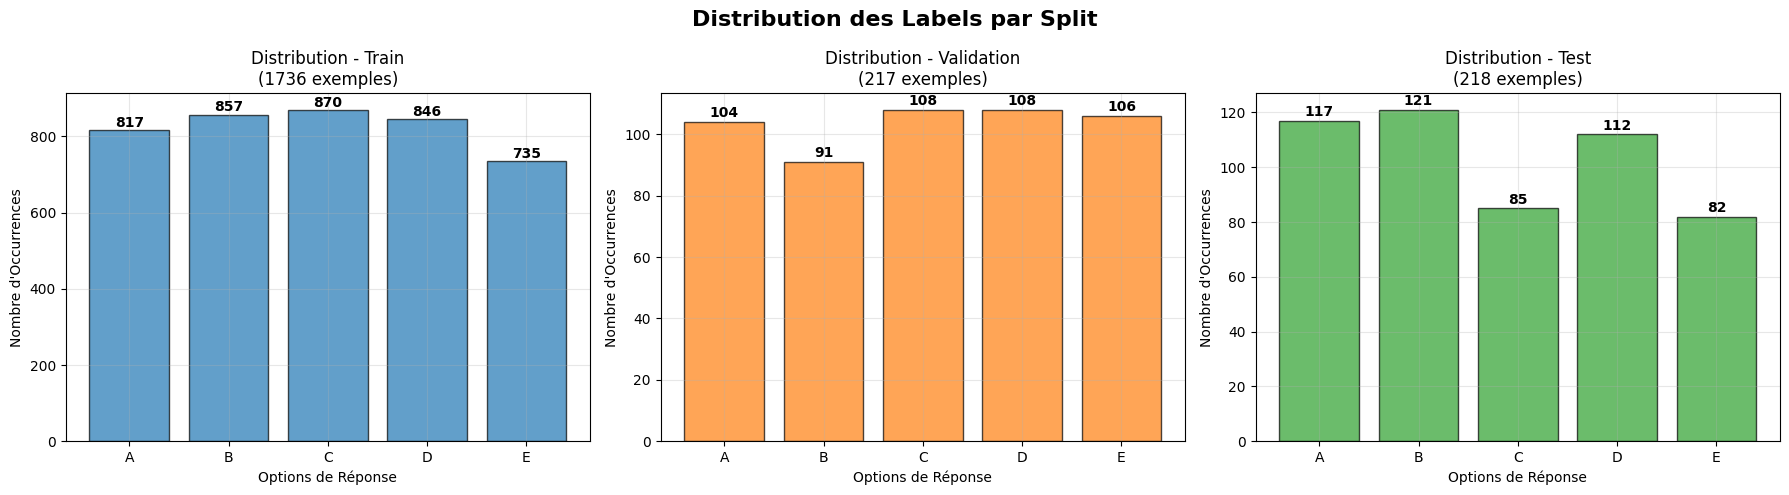

In [ ]:
# Division des données en train/validation/test
from sklearn.model_selection import train_test_split

print("=== DIVISION DES DONNÉES ===")

# Division initiale train/temp (80/20)
texts_train, texts_temp, labels_train, labels_temp = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=[sum(label) for label in labels]
)

# Division temp en validation/test (10/10 du total)
texts_val, texts_test, labels_val, labels_test = train_test_split(
    texts_temp, labels_temp, test_size=0.5, random_state=42, stratify=[sum(label) for label in labels_temp]
)

print(f"Données d'entraînement: {len(texts_train)} exemples")
print(f"Données de validation: {len(texts_val)} exemples")
print(f"Données de test: {len(texts_test)} exemples")

# Vérification de la distribution stratifiée
train_avg_labels = np.array(labels_train).sum(axis=1).mean()
val_avg_labels = np.array(labels_val).sum(axis=1).mean()
test_avg_labels = np.array(labels_test).sum(axis=1).mean()

print(f"\nVérification stratification:")
print(f"Train - moyenne labels/question: {train_avg_labels:.2f}")
print(f"Validation - moyenne labels/question: {val_avg_labels:.2f}")
print(f"Test - moyenne labels/question: {test_avg_labels:.2f}")

# Visualisation de la distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

splits = [
    ('Train', np.array(labels_train)),
    ('Validation', np.array(labels_val)),
    ('Test', np.array(labels_test))
]

for idx, (split_name, split_labels) in enumerate(splits):
    option_counts = split_labels.sum(axis=0)
    axes[idx].bar(option_names, option_counts, alpha=0.7, color=f'C{idx}', edgecolor='black')
    axes[idx].set_title(f'Distribution - {split_name}\n({len(split_labels)} exemples)')
    axes[idx].set_xlabel('Options de Réponse')
    axes[idx].set_ylabel('Nombre d\'Occurrences')
    axes[idx].grid(True, alpha=0.3)

    # Ajout des valeurs sur les barres
    for i, count in enumerate(option_counts):
        axes[idx].text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

plt.suptitle('Distribution des Labels par Split', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Entraînement du Modèle

In [ ]:
# Configuration et chargement du modèle CamemBERT
print("=== CONFIGURATION CAMEMBERT POUR MÉDICAL ===")

# Choix du modèle pour le français médical
model_name = "camembert-base"  # Alternative: "flaubert/flaubert_base_cased"

# Chargement du tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Tokenizer chargé: {model_name}")
print(f"Taille du vocabulaire: {len(tokenizer)}")

# Configuration pour classification multi-label
from transformers import AutoConfig
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=5,  # 5 options (A, B, C, D, E)
    problem_type="multi_label_classification",
    id2label={0: "A", 1: "B", 2: "C", 3: "D", 4: "E"},
    label2id={"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}
)

# Chargement du modèle
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    config=config
)

print(f"Modèle chargé avec {model.num_parameters()} paramètres")
print(f"Architecture: {type(model).__name__}")

# Test de tokenisation sur exemple médical
medical_example = texts[0]
tokens = tokenizer.tokenize(medical_example)
input_ids = tokenizer.encode(medical_example, truncation=True, max_length=512)

print(f"\nTest de tokenisation:")
print(f"Texte original: {len(medical_example)} caractères")
print(f"Tokens générés: {len(tokens)}")
print(f"Input IDs: {len(input_ids)}")
print(f"Premiers tokens: {tokens[:10]}")


=== CONFIGURATION CAMEMBERT POUR MÉDICAL ===
Tokenizer chargé: camembert-base
Taille du vocabulaire: 32005


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

CamembertForSequenceClassification LOAD REPORT from: camembert-base
Key                         | Status     | 
----------------------------+------------+-
lm_head.dense.bias          | UNEXPECTED | 
lm_head.bias                | UNEXPECTED | 
lm_head.layer_norm.weight   | UNEXPECTED | 
lm_head.layer_norm.bias     | UNEXPECTED | 
roberta.pooler.dense.bias   | UNEXPECTED | 
lm_head.dense.weight        | UNEXPECTED | 
roberta.pooler.dense.weight | UNEXPECTED | 
classifier.dense.bias       | MISSING    | 
classifier.dense.weight     | MISSING    | 
classifier.out_proj.bias    | MISSING    | 
classifier.out_proj.weight  | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Modèle chargé avec 110625797 paramètres
Architecture: CamembertForSequenceClassification

Test de tokenisation:
Texte original: 328 caractères
Tokens générés: 81
Input IDs: 83
Premiers tokens: ['▁Parmi', '▁les', '▁affirmation', 's', '▁suivantes', ',', '▁une', '▁seule', '▁est', '▁fausse']


In [ ]:
# Création d'un dataset PyTorch pour l'entraînement
import torch
from torch.utils.data import Dataset

class FrenchMedicalDataset(Dataset):
    """
    Dataset personnalisé pour questions médicales françaises multi-label
    """

    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenisation
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Création des datasets
train_dataset = FrenchMedicalDataset(texts_train, labels_train, tokenizer)
val_dataset = FrenchMedicalDataset(texts_val, labels_val, tokenizer)
test_dataset = FrenchMedicalDataset(texts_test, labels_test, tokenizer)

print(f"Datasets créés:")
print(f"  Train: {len(train_dataset)} exemples")
print(f"  Validation: {len(val_dataset)} exemples")
print(f"  Test: {len(test_dataset)} exemples")

# Test du dataset
sample = train_dataset[0]
print(f"\nÉchantillon du dataset:")
print(f"  Input IDs shape: {sample['input_ids'].shape}")
print(f"  Attention mask shape: {sample['attention_mask'].shape}")
print(f"  Labels shape: {sample['labels'].shape}")
print(f"  Labels: {sample['labels'].tolist()}")

# Analyse de la longueur des séquences tokenisées
sequence_lengths = []
for text in texts_train[:100]:  # Échantillon pour analyse
    tokens = tokenizer.encode(text, truncation=False)
    sequence_lengths.append(len(tokens))

print(f"\nAnalyse des longueurs de séquences:")
print(f"  Longueur moyenne: {np.mean(sequence_lengths):.1f} tokens")
print(f"  Longueur médiane: {np.median(sequence_lengths):.1f} tokens")
print(f"  Longueur maximale: {max(sequence_lengths)} tokens")
print(f"  % séquences > 512 tokens: {sum(1 for l in sequence_lengths if l > 512)/len(sequence_lengths)*100:.1f}%")

Datasets créés:
  Train: 1736 exemples
  Validation: 217 exemples
  Test: 218 exemples

Échantillon du dataset:
  Input IDs shape: torch.Size([512])
  Attention mask shape: torch.Size([512])
  Labels shape: torch.Size([5])
  Labels: [1.0, 0.0, 1.0, 1.0, 1.0]

Analyse des longueurs de séquences:
  Longueur moyenne: 92.0 tokens
  Longueur médiane: 86.0 tokens
  Longueur maximale: 226 tokens
  % séquences > 512 tokens: 0.0%


In [ ]:
# Configuration de l'entraînement optimisée pour Colab
print("=== CONFIGURATION D'ENTRAÎNEMENT ===")

training_args = TrainingArguments(
    output_dir='./medical_french_classifier',
    num_train_epochs=3,  # Réduction pour Colab
    per_device_train_batch_size=8,  # Optimisé pour mémoire GPU
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    learning_rate=2e-5,
    logging_dir='./logs',
    logging_steps=50,
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=200,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    save_total_limit=2,
    dataloader_num_workers=0,  # Évite les problèmes de multiprocessing
    fp16=torch.cuda.is_available(),  # Optimisation mémoire GPU
    gradient_checkpointing=True,  # Économie mémoire
    dataloader_pin_memory=False,
    remove_unused_columns=False
)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    """
    Calcule les métriques d'évaluation pour classification multi-label
    """
    predictions, labels = eval_pred

    # Conversion des probabilités en prédictions binaires
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = (probs > 0.5).int().numpy()
    y_true = labels.astype(int)

    # Métriques globales
    exact_match = accuracy_score(y_true, y_pred)
    # Métriques par classe (micro et macro)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='micro', zero_division=0
    )
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )

    return {
        'exact_match': exact_match,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'precision_micro': precision_micro,
        'precision_macro': precision_macro,
        'recall_micro': recall_micro,
        'recall_macro': recall_macro,
    }


# Initialisation du trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

print(f"Configuration d'entraînement:")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Batch size (train): {training_args.per_device_train_batch_size}")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Optimisations mémoire: FP16={training_args.fp16}, Gradient checkpointing={training_args.gradient_checkpointing}")

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


=== CONFIGURATION D'ENTRAÎNEMENT ===
Configuration d'entraînement:
  Epochs: 3
  Batch size (train): 8
  Learning rate: 2e-05
  Optimisations mémoire: FP16=True, Gradient checkpointing=True


In [ ]:
# Entraînement
print("Début de l'entraînement...")
trainer.train()
print("Entraînement terminé")

## 6. Évaluation et Performance

In [ ]:
# Évaluation sur le jeu de test
results = trainer.evaluate()
print("Résultats d'évaluation:")
for metric, value in results.items():
    if metric.startswith('eval_'):
        metric_name = metric.replace('eval_', '')
        print(f"{metric_name}: {value:.3f}")

Résultats d'évaluation:
loss: 0.693
model_preparation_time: 0.011
exact_match: 0.014
f1_micro: 0.400
f1_macro: 0.249
precision_micro: 0.458
precision_macro: 0.381
recall_micro: 0.356
recall_macro: 0.367
runtime: 2.200
samples_per_second: 98.650
steps_per_second: 6.364


In [ ]:
# Évaluation sur le dataset de test
print("=== ÉVALUATION SUR DATASET DE TEST ===")

# Prédictions sur le dataset de test
test_results = trainer.predict(test_dataset)
test_predictions = test_results.predictions
test_labels = test_results.label_ids

# Conversion des logits en probabilités et prédictions
sigmoid = torch.nn.Sigmoid()
test_probs = sigmoid(torch.Tensor(test_predictions)).numpy()
test_pred_binary = (test_probs > 0.5).astype(int)

print(f"Prédictions générées pour {len(test_predictions)} exemples")
print(f"Shape des prédictions: {test_pred_binary.shape}")

# Calcul des métriques détaillées
metrics = compute_metrics((test_predictions, test_labels))

print(f"\n=== MÉTRIQUES MICRO (globales) ===")
print(f"Precision: {metrics['precision_micro']:.4f}")
print(f"Recall: {metrics['recall_micro']:.4f}")
print(f"F1-Score: {metrics['f1_micro']:.4f}")

print(f"\n=== MÉTRIQUES MACRO (moyennées par classe) ===")
print(f"Precision: {metrics['precision_macro']:.4f}")
print(f"Recall: {metrics['recall_macro']:.4f}")
print(f"F1-Score: {metrics['f1_macro']:.4f}")

# Métriques par classe
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    test_labels, test_pred_binary, average=None, zero_division=0
)

print(f"\n=== MÉTRIQUES PAR OPTION ===")
option_names = ['A', 'B', 'C', 'D', 'E']
for i, option in enumerate(option_names):
    print(f"Option {option}:")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall: {recall_per_class[i]:.4f}")
    print(f"  F1-Score: {f1_per_class[i]:.4f}")
    print(f"  Support: {support_per_class[i]}")

=== ÉVALUATION SUR DATASET DE TEST ===


Prédictions générées pour 218 exemples
Shape des prédictions: (218, 5)

=== MÉTRIQUES MICRO (globales) ===
Precision: 0.4625
Recall: 0.3578
F1-Score: 0.4035

=== MÉTRIQUES MACRO (moyennées par classe) ===
Precision: 0.3873
Recall: 0.3654
F1-Score: 0.2481

=== MÉTRIQUES PAR OPTION ===
Option A:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 117
Option B:
  Precision: 0.5495
  Recall: 0.8264
  F1-Score: 0.6601
  Support: 121
Option C:
  Precision: 0.3871
  Recall: 0.9882
  F1-Score: 0.5563
  Support: 85
Option D:
  Precision: 0.0000
  Recall: 0.0000
  F1-Score: 0.0000
  Support: 112
Option E:
  Precision: 1.0000
  Recall: 0.0122
  F1-Score: 0.0241
  Support: 82


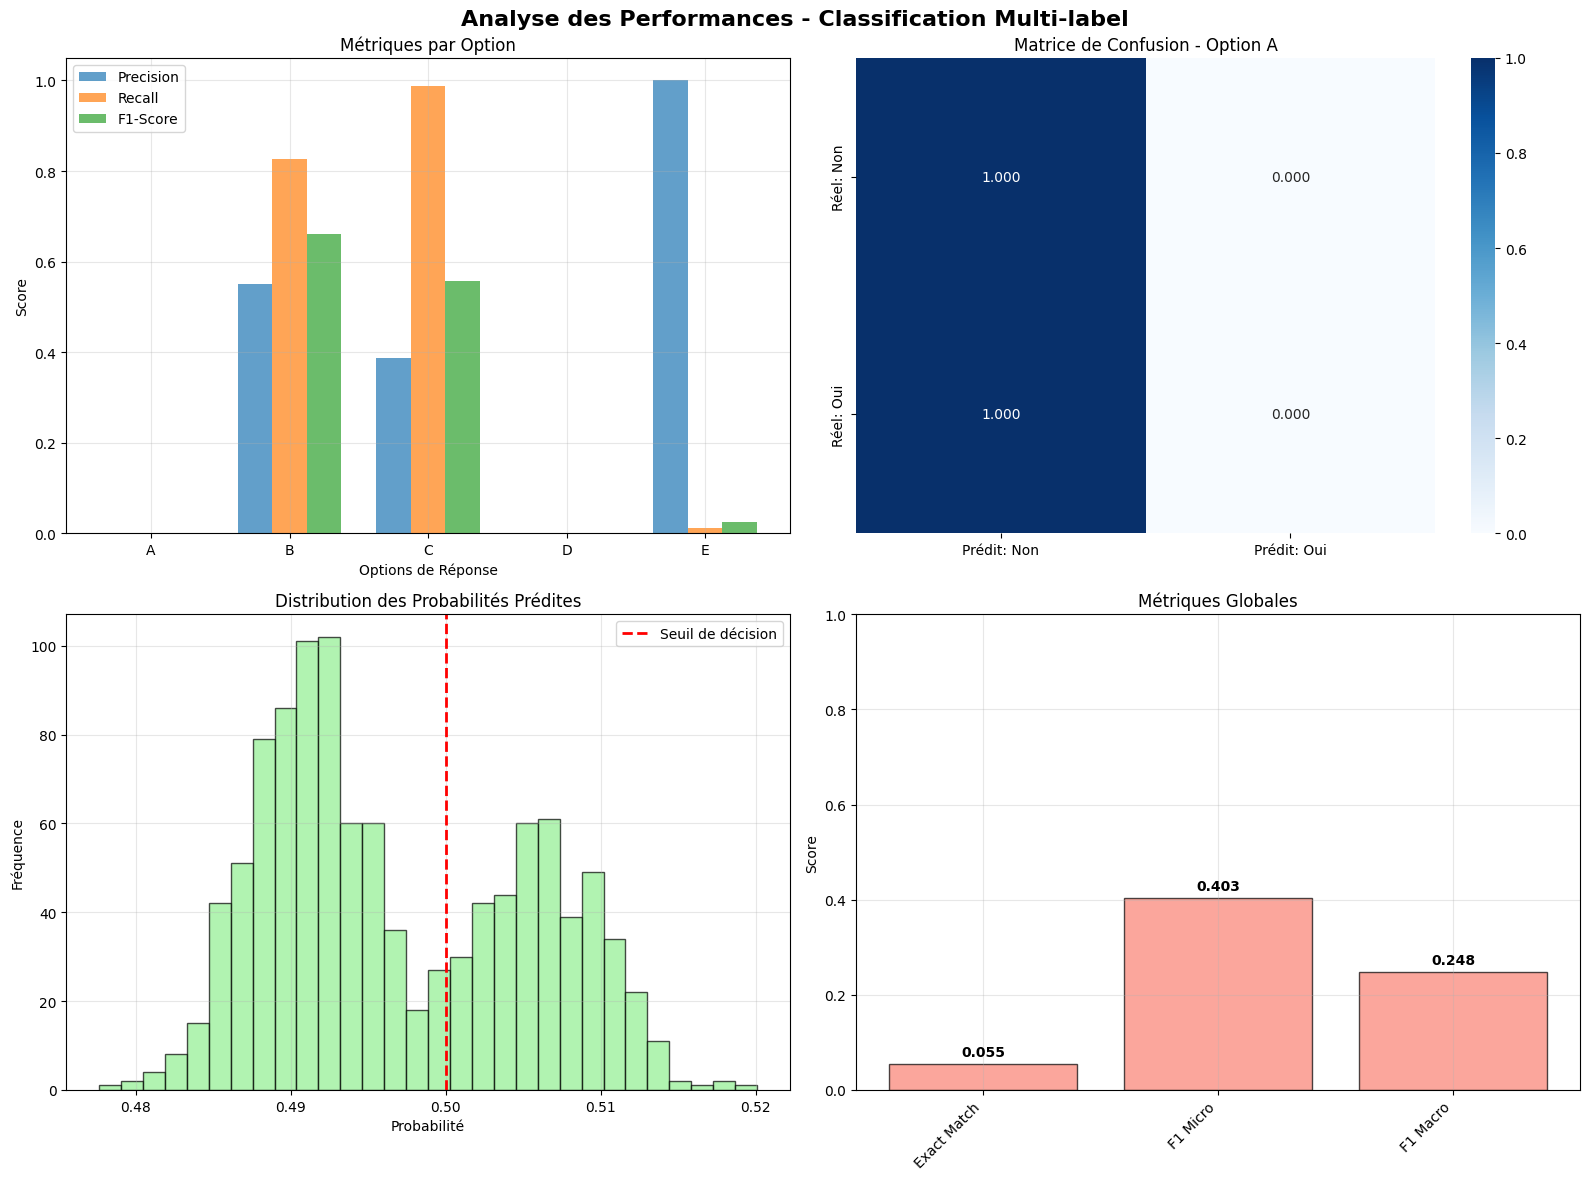

In [ ]:
# Visualisation des performances
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analyse des Performances - Classification Multi-label', fontsize=16, fontweight='bold')

# 1. Métriques par classe
x = np.arange(len(option_names))
width = 0.25

axes[0, 0].bar(x - width, precision_per_class, width, label='Precision', alpha=0.7)
axes[0, 0].bar(x, recall_per_class, width, label='Recall', alpha=0.7)
axes[0, 0].bar(x + width, f1_per_class, width, label='F1-Score', alpha=0.7)

axes[0, 0].set_xlabel('Options de Réponse')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Métriques par Option')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(option_names)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Matrice de confusion par classe
conf_matrices = multilabel_confusion_matrix(test_labels, test_pred_binary)
conf_matrix_normalized = np.zeros((5, 2, 2))

for i in range(5):
    cm = conf_matrices[i]
    conf_matrix_normalized[i] = cm / cm.sum(axis=1, keepdims=True)

# Affichage de la matrice pour l'option A comme exemple
sns.heatmap(conf_matrix_normalized[0], annot=True, fmt='.3f', cmap='Blues',
            xticklabels=['Prédit: Non', 'Prédit: Oui'],
            yticklabels=['Réel: Non', 'Réel: Oui'],
            ax=axes[0, 1])
axes[0, 1].set_title('Matrice de Confusion - Option A')

# 3. Distribution des scores de confiance
axes[1, 0].hist(test_probs.flatten(), bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Seuil de décision')
axes[1, 0].set_xlabel('Probabilité')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution des Probabilités Prédites')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Comparaison des métriques globales
global_metrics = {
    'Exact Match': metrics['exact_match'],
    'F1 Micro': metrics['f1_micro'],
    'F1 Macro': metrics['f1_macro'],
}

metric_names = list(global_metrics.keys())
metric_values = list(global_metrics.values())

bars = axes[1, 1].bar(metric_names, metric_values, alpha=0.7, color='salmon', edgecolor='black')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Métriques Globales')
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(True, alpha=0.3)
plt.setp(axes[1, 1].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Ajout des valeurs sur les barres
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## Résumé

### Approches Testées

1. **Prompting Simple**: Instructions directes pour ChatGPT
2. **Few-Shot Learning**: Utilisation d'exemples dans le prompt pour guider le modèle
3. **Classification Automatique**: Entraînement d'un modèle CamemBERT spécialisé

### Applications Pratiques

- **Prompting**: Idéal pour des cas d'usage ponctuels ou des domaines très spécialisés
- **Classification**: Recommandée pour des volumes importants et des besoins de rapidité
- **Hybride**: Combiner prompting pour la validation et classification pour le traitement en masse

Le prochain notebook explorera l'analyse d'images médicales avec TorchXRayVision.